# Technical Summary of Process and Results

## Summary

## Table of Contents

* [0. Preliminaries and Setup Instructions](#preliminaries)
    * [0.1 PostgreSQL / PostGIS setup](#postgres)
    * [0.2 Configuring Your Database Connection in CaBi](#config-files)
    * [0.3 Conda Environment](#conda-env)
    * [0.4 The CaBi Package](#cabi-package)
* [1. Data Sources](#data-sources)
    * [1.1 Extract](#extract)
    * [1.2 Initial EDA](#eda-initial)
* [2. Data Preparation](#data-prep)
    * [2.1 Data Processing Steps](#data-processing)
    * [2.2 Pre-Modeling EDA](#eda-processed)
    * [2.3 Final Cleaning Approach](#data-cleaned)
    * [2.4 Load Cleaned Results to PostGIS (optional)](#data-load)
* [3. The Business Problem: Framing Our Modeling Approach](#business-problem)
    * [3.1 Background](#business-background)
    * [3.2 Goals](#business-goals)
        * [3.2.1 Countercyclical Areas](#countercyclical)
        * [3.2.2 Detecting Anomalies](#anomalies)
* [4. Modeling](#modeling)
    * [4.0 Historical Comparison of Data](#model-historical)
        * [4.0.1 Normal Range of Variance](#variance-benchmark)
    * [4.1 Benchmark: Baseline Model](#baseline)
    * [4.2 Model Evaluation Approach](#evaluation-approach)
        * [4.2.1 Tuning Comparison Criteria - AIC](#evaluation-aic)
        * [4.2.2 Cross Validation Method](#evaluation-cv)
        * [4.2.3 Out of Sample Performance - RMSE/SMAPE](#evaluation-oos)
    * [4.3 SARIMA](#sarima)
        * [4.3.1 Model Summary](#sarima-summary)
        * [4.3.2 Out of Sample Performance](#sarima-performance)
        * [4.3.3 Power Transforms](#sarima-tranforms)
        * [4.3.4 Structural Limitations](#sarima-limits)
    * [4.4 SARIMAX: Adding Exogenous Features](#sarimax)
        * [4.4.1 Date Features](#exog-date)
        * [4.4.2 Fourier Approach](#exog-fourier)
        * [4.4.3 Dummy Filter](#dummy-filter)
    * [4.5 Markov Extension: Regime Switching](#markov)
    * [4.6 Best Model](#best-model)
* [5. Evaluation/Results](#results)
* [6. Business Recommendations](#business-recommendations)
* [7. Further Research/Future Improvements](#further-research)
* [8. Sources](#sources)





## 0. Preliminaries and Setup Instructions <a class="anchor" id="preliminaries"></a>

This section is primarily intended for the user to be able to replicate the results of this analysis or extend it more comfortably on new data. Below, I outline the steps for: initializing a PostgreSQL/PostGIS database, creating a config.py file which is necessary to use the database functionality of the CaBi (Capital Bikeshare) package, using the conda environment provided for the project, and installing the CaBi package for local use.


### 0.1 PostgreSQL / PostGIS <a class="anchor" id="postgres"></a>

Though it is not strictly necessary for the scope of this project as it stands, I highly recommend the use of PostgreSQL/PostGIS as an intermediate storage method if the user plans to revisit the data more than once or twice. The geopandas pickling/other traditional file formats are a bit finicky, and this approach has several advantages. First among these is flexibility with respect to the volume of data handled at any one time. A database approach, in contrast to a pandas dataframe for example, allows the user to load a smaller selection of areas to model at one time, while storing the majority of records elsewhere. Geographical data are already a bit larger to traditional datatypes and if the user wishes to observe longer periods of time the number of observations quickly expands into the millions after just a few months of trip history. Next is extensibility; below we work primarily with counts from a modeling perspective, but in addition to new trips information becoming available monthly, there are a number of logical extensions to this method which incorporate for example, weather data, in conjunction with additional features of the dataset not used for this phase of the project.  A database is well-suited to handle joining and automatically updating these features.

One can find the installation instructions for PostgreSQL on their website along with other helpful resources: https://www.postgresql.org/
The EDB installer is available for download here: https://www.enterprisedb.com/downloads/postgres-postgresql-downloads
For this project we utilize PostGIS to store point geometries for longitude/latitude coordinates. You can install PostGIS as part of the "Stack Builder" application distributed with the EDB installer referenced above, or find instructions on their website: https://postgis.net/install/

Database schema utilized was a default PostgreSQL database named "CABI", which the user can create by using either psql or pgAdmin, and all tables will be generated below directly from python. If it's your first time using postgres/postGIS, you can find a good guide to setting up the database schema here: https://www.e-education.psu.edu/spatialdb/node/1958, but remember to use the name "CABI." 


One serious advantage of the database approach is that it allows the data to be accessed from more than one computer. For this project I only used a single user and a local network access permission scheme, but it could easily be scaled. It is presumed that users for whom it makes sense to distribute data more than locally, and/or set up multiple user permissions are capable of doing so. However, for those more casual users who would like to utilize the local network approach, instructions are available here: https://www.postgresql.org/docs/12/auth-pg-hba-conf.html

An additional note to the first time user wishing to access the database from their local network, which is poorly addressed in the above documentation: once you have modified the pg_hba.conf file, it is necessary to connect to the PostgreSQL instance and run the following, otherwise the modifications will not be recognized:

```SELECT pg_reload_conf()```


### 0.2 Configuring Your Database Connection in CaBi <a class="anchor" id="config-files"></a>

We use a rudimentary method to prevent the user's login credentials from being shared, in order for the CaBi package to work correctly with the database functionality, please do the following *prior to installing the CaBi package.*

    1. After forking and cloning the project locally, create a file named "config.py" in cabi/etl
    2. In config.py define the function connection_params in the following format, filling in the four parameters with the values you defined in setting up the CABI database above:
    
   ```python
    def connection_params():
        return 'postgresql://<user>:<password>@<address>:<port>/CABI'
   ```
           
       Note, defaults are probably postgres for user, localhost for address, unless you are connecting over a local network, and 5432 for port, unless you have chosen a different one during setup.
        

### 0.3 Conda Environment <a class="anchor" id="conda-env"></a>

Unfortunately, due to a bug in statsmodels 0.12 release (which by and large is excellent and contains several useful features which we make use of below) there is a compatibility issue between pmdarima's current release 1.7.1, and statsmodels 0.12. By the time you read this the issue may be resolved, however as of now there is a carefully researched fix included in this repository.  Please note that the following should work and has been tested on Mac OSX and Linux, but there may be some lingering issues for Windows users. In the event that conda is unable to solve the included environment we suggest that you remove the version constraint from statsmodels (pmdarima will want it to be less than 0.12 (opposite of what is specified in the environment file).  This will result in loss of ability to run the sections in modeling on Markov Regime Switching, but as discussed we do not select this as our final model due to the out of sample prediction limitations.  Here are the steps we recommend to recreate the environment for this project. Seasoned conda users may want to reference the discussion thread here, especially the detailed answer given by pmdarima maintainer aaronreidsmith towards the end of the thread: https://github.com/alkaline-ml/pmdarima/issues/326 

First, try the following from the home directory of this repo:

``` conda env create -f environment.yaml ``` 

If you encounter an issue where the above approach "hangs" when solving environment, the first recommendation is to update conda with

``` conda update conda ```

Next, if still having an issue with hanging solve, this may take a moment to solve, but should do the trick. Run the following prior to creating the environment to limit the search space (note this should not be necessary for most users):

``` conda config --set channel_priority strict ```

Once the environment is in place, we need to install pmdarima. In order to do that without causing the above-mentioned compatibility issue, we have adapted meta.yaml file as discussed in the github issue referenced above. It is available in the pmdarima directory of this repository. Please feel free to inspect the meta.yaml before installing for details on the work-around. Next, the user will need to run the following from the home directory of this repository. First, if you have not already activated, the new environment, run:

``` conda activate cabi-env ```

Once the new environment is activated run:

``` conda-build pmdarima ```

This will generate a local channel from which you can install pmdarima. For more details please see: https://docs.conda.io/projects/conda-build/en/latest/user-guide/tutorials/build-pkgs-skeleton.html

If you previously set channel prirority you will next need to reset it with either "false" as shown below, or "flexible"

``` conda config --set channel_priority false ```

Next, we install pmdarima with our new local channel. Copy the channel location output from conda-build (should look something like this: /opt/anaconda3/envs/cabi-env/conda-bld/osx-64/pmdarima-1.7.1-py38h1de35cc_0.tar.bz2 ), then run:

```conda config --add channels <YOUR-LOCAL-CHANNEL> ```

And last, to complete installation run:

```conda install pmdarima```


### 0.4 The CaBi package <a class="anchor" id="cabi-package"></a>

The helper functions used in this project are packaged together as CaBi, which the user can install locally to fully reproduce all steps. After creating the config.py file (important that this be done in order!) navigate to the home directory of the project from the command line and run one of the following commands according to whether or not you're using conda environment.  Both are installed with develop, so that the user can edit the underlying scripts as desired.

If using conda:

```conda develop . ```

To install, and to uninstall:

```conda develop -u . ```

If not using conda (substitute with python3 on systems that differentiate):

``` python setup.py develop ```

To install, and to uninstall:

``` python setup.py develop --uninstall ```


Last step in the setup process is to add a kernel for the environment so you can use it inside of Jupyter:

``` ipython kernel install --user --name=cabi-env ``` 



## 1. Data Sources <a class="anchor" id="data-sources"></a>

Several sources of raw data were utilized for this project.  All are listed here with a brief description:

1. The Primary Source of Data for this project is the trips history released monthly by Capital Bikeshare. This can be found at https://s3.amazonaws.com/capitalbikeshare-data/index.html


2. This project utilizes several of the shapefiles available from Open Data DC for comparing locations and mapping. These are:
    - DC Advisory Neighborhood Commission Shapefiles: "https://opendata.arcgis.com/datasets/fcfbf29074e549d8aff9b9c708179291_1.geojson"
    - DC Boundary Line: "https://opendata.arcgis.com/datasets/7241f6d500b44288ad983f0942b39663_10.geojson"


3. Last, the region and station info from Capital Bikeshare is obtained from:
    - Capital Bikeshare Regions were used to speed up some of the geographic comparisons made on the point geometries below. These can be found at 'https://gbfs.capitalbikeshare.com/gbfs/en/system_regions.json'
    - Capital Bikeshare Stations Information was not utilized in real time (though this is certainly an area for improvement), but was used similarly for geometric comparisons as well as some mapping: https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json

### 1.1 Extract <a class="anchor" id="extract"></a>

The project setup was designed to loosely mimic an ETL structure to facilitate the building out of postgres triggers and automated collection in future. The functions for gathering the raw data from source can be found in cabi.etl.extract, we walk through them here to show how they can be used to replicate the project structure.






In [1]:
import cabi.etl.extract as extract
import cabi.etl.load as l
import cabi.etl.transform as t
import cabi.cleaning as clean
import cabi.viz as viz
import pandas as pd

In [2]:
out

NameError: name 'out' is not defined

In [2]:
# Builds the data/raw directory, containing csv files downloaded in zip format 
# from https://s3.amazonaws.com/capitalbikeshare-data/index.html and unzipped in data/raw
# see comments in cabi.etl.extract for a breakdown of each function in the sequence called here
## Note to user, the resulting directory will be around 1.1 GB
extract.build_raw_data()

created directory ~/data/raw with contents: ['201805-capitalbikeshare-tripdata.csv', '201910-capitalbikeshare-tripdata.csv', '202004-capitalbikeshare-tripdata.csv', '201901-capitalbikeshare-tripdata.csv', '201802-capitalbikeshare-tripdata.csv', '201909-capitalbikeshare-tripdata.csv', '202003-capitalbikeshare-tripdata.csv', '201906-capitalbikeshare-tripdata.csv', '202005-capitalbikeshare-tripdata.csv', '201911-capitalbikeshare-tripdata.csv', '201804-capitalbikeshare-tripdata.csv', '202002-capitalbikeshare-tripdata.csv', '201907-capitalbikeshare-tripdata.csv', '201812-capitalbikeshare-tripdata.csv', '201908-capitalbikeshare-tripdata.csv', '201803-capitalbikeshare-tripdata.csv', '202001-capitalbikeshare-tripdata.csv', '201904-capitalbikeshare-tripdata.csv', '201811-capitalbikeshare-tripdata.csv', '202006-capitalbikeshare-tripdata.csv', '201903-capitalbikeshare-tripdata.csv', '201808-capitalbikeshare-tripdata.csv', '201912-capitalbikeshare-tripdata.csv', '201807-capitalbikeshare-tripdata.c

In [3]:
# Extracts all csvs in the raw directory just created above into one list of dataframes
# corresponding to each csv
raw_dfs = extract.dfs_from_raw()

raw_dfs

[        Duration           Start date             End date  \
 0            552  2018-01-01 00:05:06  2018-01-01 00:14:18   
 1           1282  2018-01-01 00:14:30  2018-01-01 00:35:53   
 2           1265  2018-01-01 00:14:53  2018-01-01 00:35:58   
 3            578  2018-01-01 00:15:31  2018-01-01 00:25:09   
 4            372  2018-01-01 00:18:02  2018-01-01 00:24:15   
 ...          ...                  ...                  ...   
 168585      1377  2018-01-31 23:50:17  2018-02-01 00:13:14   
 168586       761  2018-01-31 23:52:43  2018-02-01 00:05:24   
 168587       738  2018-01-31 23:54:27  2018-02-01 00:06:45   
 168588       247  2018-01-31 23:56:31  2018-02-01 00:00:38   
 168589       953  2018-01-31 23:58:28  2018-02-01 00:14:22   
 
         Start station number                         Start station  \
 0                      31104           Adams Mill & Columbia Rd NW   
 1                      31321         15th St & Constitution Ave NW   
 2                      31321

### 1.2 Initial EDA <a class="anchor" id="eda-initial"></a>

##### The Columns Are Not All The Same

A good first step in any data science process is to view the column names we're dealing with. In this case we see that the naming convention for the trips data has recently changed.

In [4]:
col_names = [df.columns for df in raw_dfs]
col_names

[Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Start date', 'End date', 'Start station number',
        'Start station', 'End station number', 'End station', 'Bike number',
        'Member type'],
       dtype='object'),
 Index(['Duration', 'Star

##### But the Information Is Roughly The Same


- Notably different items are:
    - Rideable Type (All of the old sets are presumed to be Docked Bikes)
    - Missing Lat/Lng (need an imputation strategy)
    - Different Station ID/Numbering Convention (not a huge deal, since naming is consistent)
    - No Unique Ride ID (we may want to add some sort of unique identifier if using this Data)

## 2. Data Preparation <a class="anchor" id="data-prep"></a>


We're not able to join all of the trips data together at this point. We need to be able to join accross a consistent column format before continuing to look at the data so we get started with Data Processing before coming back to EDA.

### 2.1 Data Processing Steps <a class="anchor" id="data-processing"></a>

#### 2.1.1 Preparing the Raw Dataframes for Joining

First we observe that though the column names are not consistent throughout each monthly set, this appears to be due to a recent change in conventions, and the format is quite consistent in both the data prior to April of 2020, and the data after April of 2020. We define a quick test to confirm this observation, and then do some preliminary cleaning on the older "legacy" formatted data first. This process is detailed and explained in cabi.cleaning, and we reproduce the results of the full preparation process below. 

Though we do explore a strategy for imputation of latitude and longitude based on Stations in the legacy data which is quite effective, we didn not end up pursuing this line of analysis and thus do not include this step here for three main reasons.

1. Though there is some argument for exploring counts/variance in specific geographic areas on a historical basis relative to current levels, this is possible through indirect methods of imputation that do not involve the creation of a costly Point geometry column. In addition, our analysis does not explore spatial correlation except at a generalized areal level, but several researchers have tried this in the past with decent results for slightly different targets.

2. The results of our initial EDA reveal a large disruption due to COVID. As discussed below, this leads us to the decision to only use the more recent data, as it is extraordinarily difficult to cross validate further results. To break this down further our data contain what we first intuit, and then show in the modeling section are essentially at least two distinct Markov regimes in even the subset we chose. This number would increase by including the data from pre-COVID months.

3. From a business perspective, we are answering an operational rather than strategic problem, and are therefore primarily concerned with relatively short time intervals for prediction. Though it would potentially be a fair assumption that there is some larger seasonal effect on perhaps a roughly annual or biannual basis, it seems unlikely that it would contribute significantly enough to our particular question of interest to justify the increased computing power it would necessitate to approximate such a trend at the frequency we look at. It seems far more likely that exploring other exogenous features and modeling approaches would offer significantly more marginal gain, and should be explored prior to pursuing such an approach.

# **FLAGGED INSERT SOURCE FOR POINT 1**





In [5]:
# We observe that the column names are consistent for all but 
#the most recent few dataframes in the list:

clean.check_col_list(raw_dfs[:-4])

True

In [6]:
# We call only the aggregated versions here for brevity, but the
# specific steps carried out by this function can be found in the 
# comments and Docstrings in cabi.cleaning

clean.join_legacy(raw_dfs[:-4])

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual
0,0,docked_bike,2018-01-01 00:05:06,2018-01-01 00:14:18,Adams Mill & Columbia Rd NW,Georgia & New Hampshire Ave NW,member
1,1,docked_bike,2018-01-01 00:14:30,2018-01-01 00:35:53,15th St & Constitution Ave NW,15th St & Constitution Ave NW,casual
2,2,docked_bike,2018-01-01 00:14:53,2018-01-01 00:35:58,15th St & Constitution Ave NW,15th St & Constitution Ave NW,casual
3,3,docked_bike,2018-01-01 00:15:31,2018-01-01 00:25:09,14th & Upshur St NW,16th & Harvard St NW,casual
4,4,docked_bike,2018-01-01 00:18:02,2018-01-01 00:24:15,4th & East Capitol St NE,Lincoln Park / 13th & East Capitol St NE,member
...,...,...,...,...,...,...,...
7478496,7478496,docked_bike,2020-03-31 23:17:58,2020-03-31 23:29:12,19th St & Constitution Ave NW,5th St & Massachusetts Ave NW,member
7478497,7478497,docked_bike,2020-03-31 23:18:13,2020-03-31 23:26:47,14th & Rhode Island Ave NW,18th & New Hampshire Ave NW,member
7478498,7478498,docked_bike,2020-03-31 23:29:00,2020-03-31 23:54:25,20th St & Florida Ave NW,5th & Kennedy St NW,member
7478499,7478499,docked_bike,2020-03-31 23:41:17,2020-03-31 23:50:43,1st & M St NE,10th & E St NW,member


##### The Full Set of Trips Available from Jan 2018 - End of July 2020

In [7]:
# See code in cabi.cleaning, calls separate methods on
# legacy formatted dfs(raw_dfs up until last four) and recent formatted
# dfs (raw_dfs from April on), returns one formatted df indexed by time
full = clean.merge_all(raw_dfs[:-4], raw_dfs[-4:])
full

,ride_id,rideable_type,ended_at,start_station_name,end_station_name,member_casual
started_at,,,,,,
2018-01-01 00:05:06,0,docked_bike,2018-01-01 00:14:18,Adams Mill & Columbia Rd NW,Georgia & New Hampshire Ave NW,member
2018-01-01 00:14:30,1,docked_bike,2018-01-01 00:35:53,15th St & Constitution Ave NW,15th St & Constitution Ave NW,casual
2018-01-01 00:14:53,2,docked_bike,2018-01-01 00:35:58,15th St & Constitution Ave NW,15th St & Constitution Ave NW,casual
2018-01-01 00:15:31,3,docked_bike,2018-01-01 00:25:09,14th & Upshur St NW,16th & Harvard St NW,casual
2018-01-01 00:18:02,4,docked_bike,2018-01-01 00:24:15,4th & East Capitol St NE,Lincoln Park / 13th & East Capitol St NE,member
...,...,...,...,...,...,...
2020-07-31 23:59:19,6773DA8ECF127D24,docked_bike,2020-08-01 00:10:33,Columbia Rd & Georgia Ave NW,Edgewood Rec Center,casual
2020-07-31 23:59:31,D5ADBB8824CE39BB,docked_bike,2020-08-01 00:08:07,Eastern Market Metro / Pennsylvania Ave & 7th ...,Massachusetts Ave & 6th St NE,member
2020-07-31 23:59:39,D526E34BD02BB5DC,docked_bike,2020-08-01 00:18:36,Henry Bacon Dr & Lincoln Memorial Circle NW,New Hampshire Ave & Ward Pl NW,casual


### 2.2 Pre-Modeling EDA <a class="anchor" id="eda-processed"></a>

##### We First View Basic Information on the Full Set

In [8]:
# Dtypes are as expected after cleaning
# We have a little more than 800,000 observations
# Start time of the rides ranges from January 1, 2018
# to July 31, 2020, which is likewise as expected
full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8145033 entries, 2018-01-01 00:05:06 to 2020-07-31 23:59:46
Data columns (total 6 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   ended_at            datetime64[ns]
 3   start_station_name  object        
 4   end_station_name    object        
 5   member_casual       object        
dtypes: datetime64[ns](1), object(5)
memory usage: 435.0+ MB


In [9]:
# Overwhelming Tendency towards Member vs. non-member
# The most frequent stations are not as pronounced, but
# still make up a large portion of the data
# We were successful in making sure that each ride had
# a unique ride id, docked_bike, though imputed on large
# portion of the data, make up large portion of observations
# as expected since ebikes just introduced recently
full.describe(datetime_is_numeric=False)

<ipython-input-9-c54e979ea213>:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  full.describe(datetime_is_numeric=False)


,ride_id,rideable_type,ended_at,start_station_name,end_station_name,member_casual
count,8145033,8145033,8145033,8141061,8137542,8145033
unique,8145033,2,7335248,695,695,2
top,A13B7A80C23C1883,docked_bike,2020-07-23 11:24:51,Columbus Circle / Union Station,Columbus Circle / Union Station,member
freq,1,8129184,16,134536,144759,6579624
first,NaN,NaN,2018-01-01 00:14:18,NaN,NaN,NaN
last,NaN,NaN,2020-08-10 20:25:12,NaN,NaN,NaN


In [10]:
# This reveals some potentially bad data, given the 
# oldest start time we saw above, this would have been
# an extremely long trip for the oldest trip in the set
# ending on 08-10
# note how much of the data is centered in a roughly
# 14 month period
full.describe(datetime_is_numeric=True)

,ended_at
count,8145033
mean,2019-03-12 23:12:59.282739712
min,2018-01-01 00:14:18
25%,2018-07-28 08:02:39
50%,2019-03-29 14:19:55
75%,2019-09-21 18:51:35
max,2020-08-10 20:25:12


In [11]:
# viewing the top values in each column:
for col in full:
    val_counts = full[col].value_counts().head()
    print(f'{col}: \n{val_counts}')


ride_id: 
A13B7A80C23C1883    1
2715015             1
2715002             1
2715003             1
2715004             1
Name: ride_id, dtype: int64
rideable_type: 
docked_bike      8129184
electric_bike      15849
Name: rideable_type, dtype: int64
ended_at: 
2020-07-23 11:24:51    16
2020-07-23 11:24:50    12
2020-07-23 11:24:52    10
2020-07-23 11:24:53    10
2020-07-26 14:24:26     8
Name: ended_at, dtype: int64
start_station_name: 
Columbus Circle / Union Station    134536
Lincoln Memorial                   101867
Jefferson Dr & 14th St SW           87120
15th & P St NW                      86898
4th St & Madison Dr NW              86238
Name: start_station_name, dtype: int64
end_station_name: 
Columbus Circle / Union Station         144759
Lincoln Memorial                        101136
15th & P St NW                           93637
Jefferson Dr & 14th St SW                90331
Massachusetts Ave & Dupont Circle NW     88669
Name: end_station_name, dtype: int64
member_casual: 
membe

In [12]:
# na values by column, we intuit that likely most of the na values for start/end latitude are from dockless
# rides, this is later confirmed, in our cleaning of the more recent data, and we drop the remaining rides from the set
full.isna().sum()

ride_id                  0
rideable_type            0
ended_at                 0
start_station_name    3972
end_station_name      7491
member_casual            0
dtype: int64

##### Next We Take a Wide View of Total Trip Activity on a Daily Basis Over the Last Two Years

This yields some interesting observations, which are quite relevant to our modeling process.

1. There is, as expected, a large dropoff in daily activity due to COVID where we saw an increase in prior years.

2. The count spikes coincident with the George Floyd protests in DC in early June. We then see the more pronounced pattern that established itself prior to this event, become cemented as a COVID pattern, with lower weekly commuter rides than in years passed, and more pronounced weekly spikes coinciding with the weekend.

3. The result of this pattern is that though the counts have started to recover to slightly more normal levels, there is a very different and regular pattern in the day to day variation. Namely, there is more variance from weekday to weekend than in years past, and this produces a corresponding weekly seasonal effect which is not present to the same degree in prior years.

This leads us to the conclusion to use only the more recent data for modeling (we clean the last four months in the same manner, but only model on observations after mid June). The reason for this is that this period exhibits its own distinct seasonal pattern not present in other periods, and also it removes a misleading, artificial, and likely one-time, trend component created by the drop in activity due to COVID.

(<Figure size 1728x648 with 3 Axes>,
 (<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>))

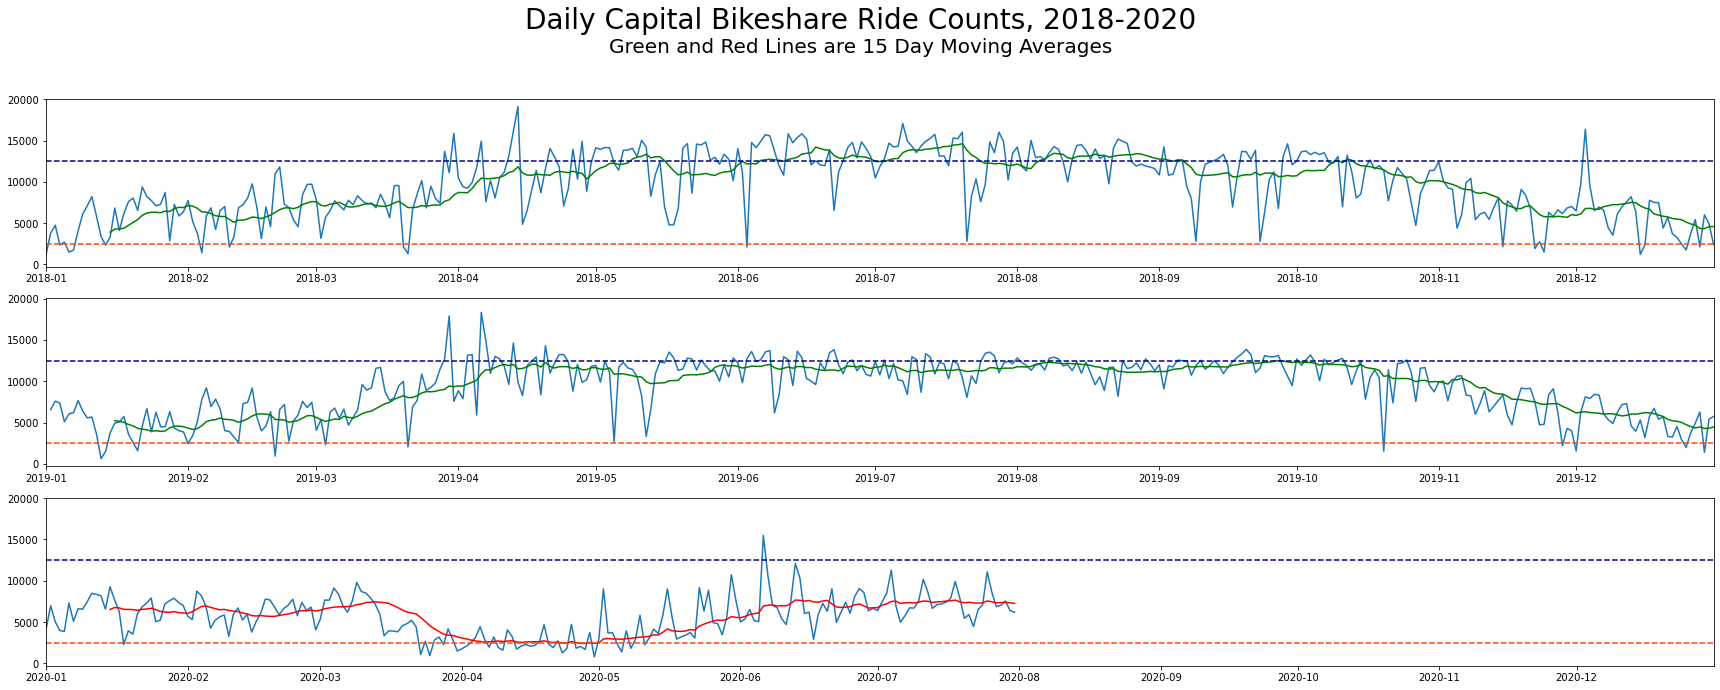

In [13]:
daily_counts = full.resample('D').count()

viz.plot_daily_counts(daily_counts)

# **FLAGGED GEOGRAPHIC RANGE--Plot Trips? Or Just Include Hotspots by Time of Day Below? I think Plot Trips/Stations, Show ANCs, Discuss Decision to Limit to DC Rides (ANCs)**

### 2.3 Final Cleaning Approach <a class="anchor" id="data-cleaned"></a>

In [18]:
recent_merged = clean.join_recent_mod(raw_dfs[-4:])

In [20]:
%%time
# Please See cabi.cleaning for full details. This function
# calls functions to clean dataframe, convert it to "long" format
# which is more suitable for the analysis outlined below
# (i.e. one row for each start and end of ride rather than one row for
# each ride with both endpoints included), and convert the longitude
# and latitude columns to one "coordinate column" containing shapely Points
# the result is a geopandas GeoDataFrame rather than a a pandas DataFrame,
# this allows the completion of the last transformation undertaken which is
# the engineering of a feature indicating which ANC each entry belongs to
# the full helper functions underlying the cabi.cleaning functions for
# constructing this feature can be found in cabi.geometry, as it was deemed
# that further geometric operations might serve as useful for analytical
# and not just cleaning purposes if one were to extend the geographical
# comparisons beyond the level of the Advisory Neighborhood Commissions
# last the cell is timed to show execution time.  Note that there is almost
# certainly some additional refactoring possible but that several improvements
# have been taken including creating a custom wrapper on Points that creates a
# hashable property which allows for caching results with functools lrucache
# and creating a dictionary of stations/locations to avoid expensive Point intersection
# calculation altogether in the event that the Point belongs to a station (as most
# do). The methods for gathering the station data can be found in cabi.extract.
# full speed up from initial attempt at this operation is approximately 18 minutes
long_geo = clean.full_transform(recent_merged)

CPU times: user 40.4 s, sys: 369 ms, total: 40.7 s
Wall time: 40.8 s


In [21]:
# There are now around 1.3M observations, the frequency is irregular though, and we are interested in the ANC
# count primarily, so we convert to a convenient and flexible format for time series modeling below in plus_minus
long_geo

,ride_id,start_end,rideable_type,duration_seconds,member_casual,ANC,station_name,coord
time,,,,,,,,
2020-04-01 00:25:48,4B5CEB51ACB3FFD5,start,docked_bike,131.0,member,Outside,Eads St & 15th St S,POINT (-77.05320 38.85900)
2020-04-01 00:27:59,4B5CEB51ACB3FFD5,end,docked_bike,131.0,member,Outside,Eads St & 12th St S,POINT (-77.05430 38.86280)
2020-04-01 01:36:09,1AF6FB400919CFB9,start,docked_bike,188.0,member,2F,14th & Rhode Island Ave NW,POINT (-77.03230 38.90860)
2020-04-01 01:39:17,1AF6FB400919CFB9,end,docked_bike,188.0,member,2F,12th & L St NW,POINT (-77.02840 38.90380)
2020-04-01 01:47:36,756AD339589371A3,start,docked_bike,699.0,member,1A,14th & Irving St NW,POINT (-77.03220 38.92860)
...,...,...,...,...,...,...,...,...
2020-08-01 01:52:27,0C79916883F5FFA0,end,docked_bike,9408.0,casual,2C,10th St & Constitution Ave NW,POINT (-77.02601 38.89303)
2020-08-01 01:56:45,AC57E5DE2CFBAA8C,end,docked_bike,7272.0,casual,2E,34th & Water St NW,POINT (-77.06753 38.90373)
2020-08-01 02:50:22,31D02200D90B2080,end,docked_bike,14246.0,member,6D,10th St & L'Enfant Plaza SW,POINT (-77.02601 38.88432)


In [22]:
# See cabi.transform for full explanation of approach
# to_plus_minus returns a DataFrame of counts where the columns
# correspond to a timeseries for each ANC, with the values
# populated as 1, when a ride ends within that ANC, 0, when the
# ride starts or ends outside of the ANC, and -1 when the ride
# starts from an ANC (counts relative level of bikes over time, -1
# for bike leaving 1 for bike entering, etc.). This allows us to
# use timeseries models on checkins/checkouts for each geographic area
# (in our case the geographic unit is limited to ANC, many others have
# modeled for example, stations, and it would be possible by this method
# to model any geographic unit one is able to define in terms of lat/long)
# This particular project is limited to the DC ANCs and thus does not
# include checkin/out information for areas outside of the District
# no resampling is done at this level to allow for flexibility with
# respect to frequency described below in the modeling section

plus_minus = t.to_plus_minus(long_geo)

In [23]:
plus_minus

,2F,1A,5E,2A,6C,1B,4B,3C,2B,6B,...,5C,7E,4A,3G,3D,7B,8D,8B,7C,2D
time,,,,,,,,,,,,,,,,,,,,,
2020-04-01 00:25:48,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-04-01 00:27:59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-04-01 01:36:09,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-04-01 01:39:17,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-04-01 01:47:36,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01 01:52:27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-08-01 01:56:45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-08-01 02:50:22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.4 Load Clean Results to PostGIS (optional)<a class="anchor" id="data-load"></a>

We load the results of our cleaning operation into PostGIS. As discussed in Section 0, this is optional, but highly recommended if you plan to revisit this data more than once or twice, as the above geographic results do not always  play well with most pickling/ other typical methods of saving and accessing data, and as shown above, recomputing them is a bit of a lengthy process from a time perspective. We go ahead and load the count data as well (which is what we end up modeling for this particular project), as it is fairly trivial once a PostgreSQL instance has already been setup.

We provide the following functions from cabi.load to make this a plug-and-play process for the user once postgres is in place. They will make all resulting tables in the database for the user. Please remember that in order to use this functionality one must create a config.py containing the user's specific database credentials within cabi.etl as detailed in [0.2 Configuring Your Database Connection in CaBi.](#config-files)

If the user only plans on viewing the results within the context of this notebook, the relevant areas utilizing cabi.load in other notebooks in the repo can easily be replaced with the processed outputs produced above.

In [ ]:
# left commented for the casual user's convenience
# t.write_postgres(plus_minus)
# t.write_postgis(long_geo)

## 3. The Business Problem: Framing Our Modeling Approach <a class="anchor" id="business-problem"></a>


### 3.1 Background <a class="anchor" id="business-background"></a>

Capital Bikeshare is the largest provider of shared bicycle service in the District of Columbia. Traditionally they have provided "docked" bikes that must be parked at a station when a ride is over. However, the recent <a href="https://dcist.com/story/20/07/07/capital-bikeshare-electric-bikes-return-lyft/"> introduction of ebikes</a> in July represents the early stages of a slightly more nuanced modeling problem. The main difference between the new ebikes, and the traditional docked bikes (other than the pedal assist), is that the ebikes do not need to be parked in a dock at the end of a ride. Though around 75% of ebike rides followed traditional docking behavior in the first month of operation, the "dockless" trend grew from just a few rides initially to greater numbers toward the end of the month.  There has been considerable modeling work done on rebalancing methods in bikeshare systems, however, most of these approaches focus on the station level. As dockless behavior approaches, there will be an increasing need for more general geographic approaches to this problem. We use the Advisory Neighborhood Commission (ANC) as a convenient geographical unit from which to approach this problem due to the clear definition of boundaries, and general availability of shapefiles with which to make comparisons. We suggest a density based clustering of rides as a logical extension of the approach we've prototyped in a more useful manner.

Succinctly, the business problem we seek to address is modeling the flow of bikes in and out of geographic areas in a way that is useful for repositioning or "rebalancing" bicycles to ensure even coverage as often as possible. The more accurately we can predict this flow, the less likely it is that a given potential user of Capital Bikeshare will want a bike, but be unable to rent one (solving unmet demand). Though we do not treat this explicitly as an optimization problem as in "Dynamic Repositioning to Reduce Lost Demand in Bikesharing Systems", we are essentially seeking to model as accurately as possible a small portion of their model on a geographic, rather than station based level. The model target is "checkins" and "checkouts" from a given area, as discussed in Yexin Li's "Traffic Prediction in a Bike-Sharing System based on Hierarchical Time Series." However, we pursue the idea that geography at a more general level, rather than as a hierarchical aggregration of specific stations, will become increasingly more necessary from a business perspective, due to the above discussion of the growth in dockless vehicles.




ImportError: The descartes package is required for plotting polygons in geopandas. You can install it using 'conda install -c conda-forge descartes' or 'pip install descartes'.

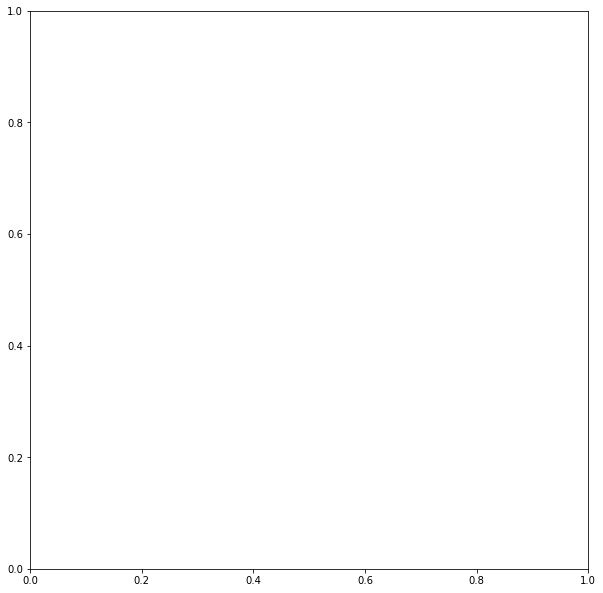

In [24]:
# We include a map of the stations and ANCs for EDA/reference purposes
viz.station_anc_map()

### 3.2 Goals <a class="anchor" id="business-goals"></a>

1. The farther out that we can predict checkins/ checkouts in a given area accurately, the more useful our model will be from a business perspective. Though it is possible to very accurately model a one-step forward approach at for example, a 15 minute frequency, it is not particularly useful from a practical perspective since a business would not have enough time to be able to use this information to deploy resources to rebalance bikes from high check-in areas to high check-out areas.
2. We attempt to find roughly countercyclical areas, so that we can provide actionable recommendations about where to rebalance bikes from areas of high supply to areas of high demand.

#### 3.2.1 Countercyclical Areas <a class="anchor" id="countercyclical"></a>

# MAP OF HOTSPOTS BY DAILY TIMES

#### 3.2.2 Detecting Anomalies <a class="anchor" id="anomalies"></a>


## 4. Modeling <a class="anchor" id="modeling"></a>

        
        

### 4.0 Historical Comparison of Data <a class="anchor" id="model-historical"></a>

#### 4.0.1 Normal Range of Variance <a class="anchor" id="variance-benchmark"></a>

### 4.1 Benchmark: Baseline Model <a class="anchor" id="baseline"></a>  

### 4.2 Model Evaluation Approach <a class="anchor" id="evaluation-approach"></a>  

#### 4.2.1 Tuning Comparison Criteria - AIC <a class="anchor" id="evaluation-aic"></a>  

#### 4.2.2 Cross Validation Method <a class="anchor" id="evaluation-cv"></a>  

#### 4.2.3 Out of Sample Performance - RMSE/SMAPE <a class="anchor" id="evaluation-oos"></a>

### 4.3 SARIMA <a class="anchor" id="sarima"></a>

#### 4.3.1 Model Summary <a class="anchor" id="sarima-summary"></a>

#### 4.3.2 Out of Sample Performance <a class="anchor" id="sarima-performance"></a>

#### 4.3.3 Power Transforms <a class="anchor" id="sarima-transforms"></a>

#### 4.3.4 Structural Limitations  <a class="anchor" id="sarima-limits"></a>

### 4.4 SARIMAX: Adding Exogenous Features  <a class="anchor" id="sarimax"></a>


#### 4.4.1 Date Features  <a class="anchor" id="exog-date"></a>


#### 4.4.2 Fourier Approach  <a class="anchor" id="exog-fourier"></a>


#### 4.4.3 Dummy Filter <a class="anchor" id="dummy-filter"></a>

### 4.5 Markov Extension: Regime Switching <a class="anchor" id="markov"></a>

### 4.6 Best Model <a class="anchor" id="best-model"></a>

## 5. Evaluation/Results  <a class="anchor" id="results"></a>


## 6. Business Recommendations <a class="anchor" id="business-recommendations"></a>


## 7. Further Research/Future Improvements <a class="anchor" id="further-research"></a>


## 8. Sources <a class="anchor" id="sources"></a>

1. Ghosh et al. "Dynamic Repositioning to Reduce Lost Demand in Bike Sharing Systems" retrieved from: http://web.mit.edu/jaillet/www/general/gvaj-jair-17.pdf

2. 